In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
'''This function takes in the data from the "data" folder( downloads if not present) and separates,
transforms into 2 parts in the respective batch sizes taken as input and returns them.'''
def load_data(train_batch_size, test_batch_size):
    # Fetch training data: total 60000 samples
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    # Fetch test data: total 10000 samples
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)

In [ ]:
''' CNN model 1
we dont initailze the max pooling layers cause its just an operation with no learnable parameters
the third fullt connected layer is the output layer.
we are not using softmax in the output .
'''
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [ ]:
''' CNN model 2
Dropout is used to prevent overfitting by just not considering some neurons during training.
and we also provide the probility of dropout.
the log_softmax  is used to give the probabilities of each class.
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

In [ ]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    n_correct = 0
    train_loss = 0
    counter = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        counter += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.data

        pred = np.argmax(output.data, axis=1)
        n_samples += target.size(0)
        n_correct += (pred == target).sum().item()
        acc = 100.0 * n_correct / n_samples

        # print log
        if batch_idx % log_interval == 0:
            print('Train set, Epoch {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.data))
            print("Train Accuracy: ", round(acc,2))
    train_loss /= counter
    return train_loss, round(acc,2)

In [ ]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)

        output = model(data)
        test_loss += loss_fn(output, target).data

        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
torch.manual_seed(1)
model= LeNet()

lr = 0.015
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr, momentum)
m0_loss_arr = []
m0_acc_arr = []

epochs = 10
log_interval = 200
for epoch in range(1, epochs + 1):
    loss, acc = train(model, optimizer, epoch, train_loader, log_interval)
    m0_loss_arr.append(loss)
    m0_acc_arr.append(acc)
    test(model, epoch, test_loader)

Train set, Epoch 1 [0/60000]	Loss: 2.322258
Train Accuracy:  10.94
Train set, Epoch 1 [12800/60000]	Loss: 0.305597
Train Accuracy:  57.0
Train set, Epoch 1 [25600/60000]	Loss: 0.281510
Train Accuracy:  73.04
Train set, Epoch 1 [38400/60000]	Loss: 0.247074
Train Accuracy:  79.8
Train set, Epoch 1 [51200/60000]	Loss: 0.208815
Train Accuracy:  83.65


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, Epoch 1 , Average loss: 0.0978, Accuracy: 9712/10000 (97%)

Train set, Epoch 2 [0/60000]	Loss: 0.100194
Train Accuracy:  93.75
Train set, Epoch 2 [12800/60000]	Loss: 0.079307
Train Accuracy:  96.28
Train set, Epoch 2 [25600/60000]	Loss: 0.309839
Train Accuracy:  96.51
Train set, Epoch 2 [38400/60000]	Loss: 0.075271
Train Accuracy:  96.76
Train set, Epoch 2 [51200/60000]	Loss: 0.081453
Train Accuracy:  96.9

Test set, Epoch 2 , Average loss: 0.0686, Accuracy: 9777/10000 (98%)

Train set, Epoch 3 [0/60000]	Loss: 0.021232
Train Accuracy:  100.0
Train set, Epoch 3 [12800/60000]	Loss: 0.072663
Train Accuracy:  97.95
Train set, Epoch 3 [25600/60000]	Loss: 0.045182
Train Accuracy:  97.8
Train set, Epoch 3 [38400/60000]	Loss: 0.018111
Train Accuracy:  97.87
Train set, Epoch 3 [51200/60000]	Loss: 0.045784
Train Accuracy:  97.9

Test set, Epoch 3 , Average loss: 0.0572, Accuracy: 9822/10000 (98%)

Train set, Epoch 4 [0/60000]	Loss: 0.102913
Train Accuracy:  98.44
Train set, Epoch 4 [1

In [ ]:
torch.manual_seed(1)

model_1= CNNModel()

lr = 0.001
momentum = 0.5
optimizer = optim.SGD(model_1.parameters(), lr=lr, momentum=momentum)
m1_loss_arr = []
m1_acc_arr = []

epochs = 10
log_interval = 200
for epoch in range(1, epochs + 1):
    loss, acc = train(model_1, optimizer, epoch, train_loader, log_interval=log_interval)
    m1_loss_arr.append(loss)
    m1_acc_arr.append(acc)
    test(model_1, epoch, test_loader)

Train set, Epoch 1 [0/60000]	Loss: 2.315159
Train Accuracy:  6.25
Train set, Epoch 1 [12800/60000]	Loss: 2.278628
Train Accuracy:  11.28
Train set, Epoch 1 [25600/60000]	Loss: 2.206332
Train Accuracy:  14.38
Train set, Epoch 1 [38400/60000]	Loss: 2.062531
Train Accuracy:  17.95
Train set, Epoch 1 [51200/60000]	Loss: 1.673731
Train Accuracy:  22.77

Test set, Epoch 1 , Average loss: 1.0213, Accuracy: 7731/10000 (77%)

Train set, Epoch 2 [0/60000]	Loss: 1.428176
Train Accuracy:  43.75
Train set, Epoch 2 [12800/60000]	Loss: 0.999658
Train Accuracy:  60.46
Train set, Epoch 2 [25600/60000]	Loss: 0.890099
Train Accuracy:  64.02
Train set, Epoch 2 [38400/60000]	Loss: 0.790145
Train Accuracy:  66.96
Train set, Epoch 2 [51200/60000]	Loss: 0.730684
Train Accuracy:  69.03

Test set, Epoch 2 , Average loss: 0.4376, Accuracy: 8877/10000 (89%)

Train set, Epoch 3 [0/60000]	Loss: 0.551022
Train Accuracy:  82.81
Train set, Epoch 3 [12800/60000]	Loss: 0.536087
Train Accuracy:  79.28
Train set, Epoch 3 

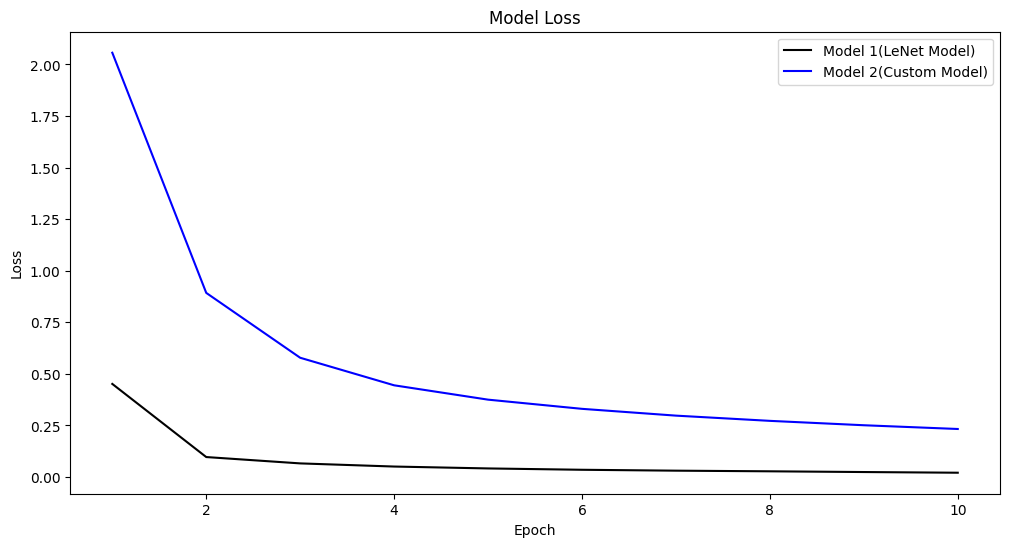

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 11, 1), m0_loss_arr, color = "black")
plt.plot(np.arange(1, 11, 1), m1_loss_arr, color = "blue")
plt.title('Model Loss')
plt.legend(['Model 1(LeNet Model)', 'Model 2(Custom Model)'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

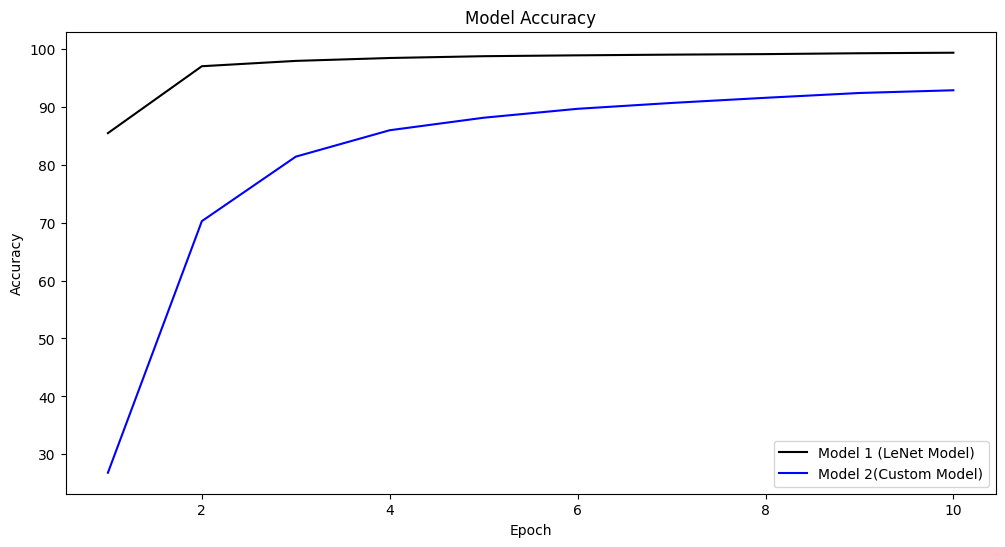

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 11, 1), m0_acc_arr, color = "black")
plt.plot(np.arange(1, 11, 1), m1_acc_arr, color = "blue")
plt.title('Model Accuracy')
plt.legend(['Model 1 (LeNet Model)', 'Model 2(Custom Model)'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()